In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew

from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchsummary
from torch.utils.data import TensorDataset, DataLoader

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
df = pd.read_csv("./data/subband_data.csv")
df = df.dropna()

In [7]:
data = df.to_numpy()
X = data[:,1:-1]
Y = data[:,-1]

#print(np.min(X))
assert(np.min(X) > 0)

X0 = X
X1 = np.log10(X0)
X0 = (X0-np.mean(X0, axis=0))/np.std(X0, axis=0)
X1 = (X1-np.mean(X1, axis=0))/np.std(X1, axis=0)

Nepochs, Nfeatures = X.shape
print(X.shape)

# reduce skew
X1_skew = skew(X1, axis=0)
X0_skew = skew(X0, axis=0)
skew_delta = np.abs(X0_skew)-np.abs(X1_skew)
skew_delta = skew_delta
#indices where we have non-beneficial log transform
bad_log_i = np.where(skew_delta < 0)
print(bad_log_i)

# ignore log transform
# X1 = X0

# # plot effect of log transform
# plt.figure()
# plt.scatter(np.arange(Nfeatures), skew_delta)
# plt.axhline(0, c="black", linestyle="--")
# plt.title("Skewness improvement with log transform")
# plt.show()

# i = np.argmax(np.abs(X1_skew))
# plt.figure()
# _ = plt.hist(X1[:,i], bins=100, label="Log transform")
# _ = plt.hist(X0[:,i], bins=100, label="Original")
# plt.legend()
# plt.title(f"Histogram of worst skewness after log transform - X{i}")
# plt.show()

# i = np.argmin(np.abs(X1_skew))
# plt.figure()
# _ = plt.hist(X1[:,i], bins=100, label="Log transform")
# _ = plt.hist(X0[:,i], bins=100, label="Original")
# plt.legend()
# plt.title(f"Histogram of best skewness after log transform - X{i}")
# plt.show()

# ignore log transform where it worsens skew
X1[:,bad_log_i] = X0[:,bad_log_i]

(97432, 22)
(array([12], dtype=int64),)


In [163]:
# METHOD 1: This doesn't work since the temporal information is not present
# We get worse results with this training method, since the models don't learn relationships between
# sleep stage transitions
def gen_random_sequence(x, y, len_sequence, nb_sequences):
    y_classes = np.unique(y)
    nb_classes = y_classes.shape[0]
    nb_features = x.shape[-1]
    
    x_seq = np.zeros((nb_sequences, len_sequence, nb_features))
    y_seq = np.zeros((nb_sequences, len_sequence))
    
    # keep track of features by class
    # goal is to rebalance the data for training
    XY = {} 
    for y_class in y_classes:
        i = (y == y_class)
        XY[y_class] = x[i]
    
    # each sequence is acquired by 
    # 1. getting a uniform random sequence of desired class outputs
    # 2. finding a random set of features from XY for each class output
    # 3. combine to generate our random but class balanced sequence
    for i in range(nb_sequences):
        y_random_classes = np.random.randint(0, nb_classes, len_sequence)
        for j in range(len_sequence):
            y_class = y_random_classes[j]
            xi = np.random.randint(XY[y_class].shape[0])
            x_rand_sample = XY[y_class][xi]
            x_seq[i,j] = x_rand_sample
            y_seq[i,j] = y_class
        
    return (x_seq, y_seq)

# create arbitary non-consecutive sequences of length N for training
# we are using interpatient random samples
# this should help our model learn inter-patient variance for sleep-stage features and transitions
# our testing set will be contiguous sequences from the same patientz
def gen_ds_inter_random(x, y, pids_mask, len_sequence, nb_sequences, train_split=0.8):
    nb_classes = np.unique(y).shape[0]
    nb_features = x.shape[-1]

    nb_total = x.shape[0]
    test_mask  = np.full((nb_total,), False)
    
    unique_pids = np.unique(pids_mask)
    nb_patients = unique_pids.shape[0]
    
    testing_seq_idxs = []
    
    # our testing set will be contiguous sequences from the same patientz
    for pid in unique_pids:
        index_mask = np.where(pids_mask == pid)[0]
        nb_epochs = index_mask.shape[0]
        
        # get non overlapping windows
        nb_windows = nb_epochs//len_sequence
        nb_windows_train = int(nb_windows*train_split)
        nb_windows_test = nb_windows-nb_windows_train
        
        # shuffle and pick random windows for testing
        j_idxs = np.arange(0, nb_epochs)
        j_non_overlap_windows = np.split(j_idxs[:nb_windows*len_sequence], nb_windows)
        np.random.shuffle(j_non_overlap_windows)
        j_test_idxs = j_non_overlap_windows[:nb_windows_test]
        j_test_idxs = np.array(j_test_idxs)
        testing_idxs = index_mask[j_test_idxs.flatten()].reshape(j_test_idxs.shape)
        testing_seq_idxs.extend(testing_idxs)
    
    testing_seq_idxs = np.array(testing_seq_idxs)
    
    # get masks for training
    train_mask = np.full((nb_total,), True)
    train_mask[testing_seq_idxs.flatten()] = False
    
    # get our testing and training datasets
    x_train, y_train = x[train_mask], y[train_mask]
    Xtest, Ytest = x[testing_seq_idxs], y[testing_seq_idxs]
    
    # generate training set from random sampling
    Xtrain, Ytrain = gen_random_sequence(x_train, y_train, len_sequence, nb_sequences)
    
    Xtrain, Ytrain = torch.tensor(Xtrain.astype(np.float32)), torch.tensor(Ytrain.astype(np.int64))
    Xtest,  Ytest  = torch.tensor(Xtest.astype(np.float32)),  torch.tensor(Ytest.astype(np.int64))

    train_ds = TensorDataset(Xtrain, Ytrain)
    test_ds = TensorDataset(Xtest, Ytest)
    
    return (train_ds, test_ds)

In [169]:
# Method 2: Maintain subsequences as consecutive
# Dividing this training set is doing to be difficult, since we
# want to be able to evaluate the model on unseen examples
# For both methods we will use overlapping sequences

# generate a subsequence from all epochs
# the patient's epochs is a list of consecutive feature vectors and corresponding label
# we use index_mask is passed, then we use that as the index for each element
# we use this if the list of epochs is spliced (has sections missing in it)
# we don't want a subsequence to skip over epochs, so we want to remain within consecutive indices
def gen_subsequence_idxs(x, y, len_sequence, index_mask):
    nb_epochs = index_mask.shape[0]
    skip_count = 0
    
    idxs = []
    
    for i in range(0, nb_epochs-len_sequence):
        # detect when we have a non-consecutive sequence
        # we skip these
        start = index_mask[i]
        end = index_mask[i+len_sequence]
        if (end-start) != len_sequence:
            skip_count += 1
            continue
            
        # get our subsequence
        y_seq = y[start:end]
        nb_y = np.unique(y_seq).shape[0]
        # if we have multiple transitions, use it
        if nb_y >= 2:
            idxs.append(index_mask[i:i+len_sequence])
            skip_count = 0
            continue
        
        # for no state changes, we take these sparingly
        skip_count += 1
        if skip_count >= (len_sequence//2):
            idxs.append(index_mask[i:i+len_sequence])
            skip_count = 0
            
    return idxs

# Method 2a: Intra-patient testing
# Have a subset of patients who we dont not train on the network
# But our model then doesn't learn how ECG data decodes for those patients potentially
def gen_ds_intra_subsequence(x, y, pids_mask, len_sequence, train_split=0.8):
    unique_pids = np.unique(pids_mask)
    nb_patients = unique_pids.shape[0]
    nb_patients_training = int(train_split*nb_patients)
    
    np.random.shuffle(unique_pids)
    pids_training = unique_pids[:nb_patients_training]
    pids_testing  = unique_pids[nb_patients_training:]
    
    training_seq_idxs = []
    testing_seq_idxs = []
    
    nb_processed = 0
    
    for pid in pids_training:
        idxs = gen_subsequence_idxs(x, y, len_sequence, np.where(pids_mask == pid)[0])
        nb_processed += 1
        print(f"\rProcessed {nb_processed:3d}/{nb_patients} with {len(idxs):6d} sequences", end="")
        training_seq_idxs.extend(idxs)
        
    for pid in pids_testing:
        idxs = gen_subsequence_idxs(x, y, len_sequence, np.where(pids_mask == pid)[0])
        nb_processed += 1
        print(f"\rProcessed {nb_processed:3d}/{nb_patients} with {len(idxs):6d} sequences", end="")
        testing_seq_idxs.extend(idxs)
    
    Xtrain, Ytrain = x[training_seq_idxs], y[training_seq_idxs]
    Xtest, Ytest = x[testing_seq_idxs], y[testing_seq_idxs]
    
    Xtrain, Ytrain = torch.tensor(Xtrain.astype(np.float32)), torch.tensor(Ytrain.astype(np.int64))
    Xtest,  Ytest  = torch.tensor(Xtest.astype(np.float32)),  torch.tensor(Ytest.astype(np.int64))

    train_ds = TensorDataset(Xtrain, Ytrain)
    test_ds = TensorDataset(Xtest, Ytest)
    
    return (train_ds, test_ds)

# Method 2b: Inter-patient testing
# All patients involved in training, but a subset of their epochs are not used for training
def gen_ds_inter_subsequence(x, y, pids_mask, len_sequence, train_split=0.8):
    unique_pids = np.unique(pids_mask)
    nb_patients = unique_pids.shape[0]
    
    training_seq_idxs = []
    testing_seq_idxs = []
    
    nb_processed = 0
    
    # for each patient, get a bunch of random subsequences than don't overlap as testing
    for pid in unique_pids:
        index_mask = np.where(pids_mask == pid)[0]
        nb_epochs = index_mask.shape[0]
        
        # get non overlapping windows
        nb_windows = nb_epochs//len_sequence
        nb_windows_train = int(nb_windows*train_split)
        nb_windows_test = nb_windows-nb_windows_train
        
        # shuffle and pick random windows for testing
        j_idxs = np.arange(0, nb_epochs)
        j_non_overlap_windows = np.split(j_idxs[:nb_windows*len_sequence], nb_windows)
        np.random.shuffle(j_non_overlap_windows)
        j_test_idxs = j_non_overlap_windows[:nb_windows_test]
        j_test_idxs = np.array(j_test_idxs)
        testing_idxs = index_mask[j_test_idxs.flatten()].reshape(j_test_idxs.shape)
        testing_seq_idxs.extend(testing_idxs)
        
        # get training windows
        j_train_mask = np.full((nb_epochs,), True)
        j_test_idxs_flat = np.array(j_test_idxs).flatten()
        j_train_mask[j_test_idxs_flat] = False
        training_idxs = index_mask[j_train_mask]
        idxs = gen_subsequence_idxs(x, y, len_sequence, training_idxs)
        training_seq_idxs.extend(idxs)
        
        nb_processed += 1
        print(f"\rProcessed {nb_processed:3d}/{nb_patients} with {len(idxs):6d} sequences", end="")
    
    Xtrain, Ytrain = x[training_seq_idxs], y[training_seq_idxs]
    Xtest, Ytest = x[testing_seq_idxs], y[testing_seq_idxs]
    
    Xtrain, Ytrain = torch.tensor(Xtrain.astype(np.float32)), torch.tensor(Ytrain.astype(np.int64))
    Xtest,  Ytest  = torch.tensor(Xtest.astype(np.float32)),  torch.tensor(Ytest.astype(np.int64))

    train_ds = TensorDataset(Xtrain, Ytrain)
    test_ds = TensorDataset(Xtest, Ytest)
    
    return (train_ds, test_ds)

In [181]:
LEN_SEQUENCE = 10
N_SEQUENCES = 100000
#train_ds, test_ds = gen_ds_inter_random(X1, Y, df['pid'], LEN_SEQUENCE, N_SEQUENCES)
#train_ds, test_ds = gen_ds_intra_subsequence(X1, Y, df['pid'], LEN_SEQUENCE)
train_ds, test_ds = gen_ds_inter_subsequence(X1, Y, df['pid'], LEN_SEQUENCE)

Processed  77/77 with    433 sequences

In [119]:
class Loss(nn.Module):
    def __init__(self):
        super(Loss, self).__init__()
        self.loss = nn.CrossEntropyLoss()
    
    def forward(self, y_pred, y_true):
        L = 0
        len_sequence = y_pred.shape[1]
        for i in range(len_sequence):
            L += self.loss(y_pred[:,i], y_true[:,i])
        return L
    
    def forward_no_seq(self, y_pred, y_true):
        return self.loss(y_pred, y_true)

def get_accuracy(y_pred, y_true):
    y_pred_cls = y_pred.argmax(dim=-1)
    acc = (y_pred_cls == y_true).float()
    return acc.mean()

In [120]:
"""
Close to the input-output HMM network structure
We get: zi = f(xi, zi-1), yi = g(xi, zi)
Where x = input, z = hidden state, y = output prediction
f(x, z) is a logistic regression model
g(x, z) is a logistic regression model
zi is the softmax of f(xi, zi-1)
yi is the softmax of g(xi, zi)

We also include an initialisation model
This is used to predict the most likely starting state for a given input
This also uses a logistic regression model and softmax
"""
class IOHMM_RNN(nn.Module):
    def __init__(self, n_inputs, n_states, n_outputs, use_input_emit=False, state_func=F.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_states = n_states
        self.n_outputs = n_outputs
        
        self.state_func = state_func
        
        self.initial_model = nn.Linear(self.n_inputs, self.n_states)
        self.transition_model = nn.Linear(self.n_inputs + self.n_states, self.n_states)
        
        self.use_input_emit = use_input_emit
        if self.use_input_emit:
            self.emission_model = nn.Linear(self.n_inputs + self.n_states, self.n_outputs)
        else:
            self.emission_model = nn.Linear(self.n_states, self.n_outputs)
    
    # Takes in an input of size (B,N,F)
    # B = batch size
    # N = sequence length
    # F = total features
    def forward(self, x, store_state=False):
        batch_size = x.shape[0]
        len_sequence = x.shape[1]
        total_features = x.shape[2]
        assert(total_features == self.n_inputs)
        
        # setup our output
        y = torch.zeros((batch_size, len_sequence, self.n_outputs)).to(device)
        if store_state:
            z = torch.zeros((batch_size, len_sequence, self.n_states)).to(device)
        
        zi = None
        for i in range(0, len_sequence):
            xi = torch.squeeze(x[:,i], axis=1)
            zi, yi = self.rnn(xi, zi)
            y[:,i] = yi
            if store_state:
                z[:,i] = zi
        
        if store_state:
            return (y, z)
        else:
            return y
    
    # return the output and next state
    def rnn(self, x, z):
        # x.shape = (B,F)
        # z.shape = (B,K)
        # xz.shape = (B,F+K)
        if z is None:
            zi = self.initial(x)
        else:
            zi = self.transition(x, z)
        yi = self.emission(x, zi)
        return (zi, yi)
    
    def initial(self, x):
        z = self.initial_model(x)
        z = self.state_func(z)
        return z
    
    def transition(self, x, z):
        xz = torch.cat([x, z], axis=1).to(device)
        zi = self.transition_model(xz)
        zi = self.state_func(zi)
        return zi
    
    def emission(self, x, z):
        if self.use_input_emit:
            xz = torch.cat([x, z], axis=1).to(device)
            yi = self.emission_model(xz)
        else:
            yi = self.emission_model(z)
        return yi

In [121]:
# same as IOHMM RNN except our f(x, z) and g(x, z) are multilayer perceptrons
class IOHMM_RNN_Multilayer(nn.Module):
    def __init__(self, n_inputs, n_states, n_outputs, use_input_emit=False, state_func=F.sigmoid):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_states = n_states
        self.n_outputs = n_outputs
        
        self.state_func = state_func
        
        self.initial_model = nn.Linear(self.n_inputs, self.n_states)
        self.transition_model_fc1 = nn.Linear(self.n_inputs+self.n_states, 100)
        self.transition_model_fc2 = nn.Linear(100, self.n_states)
        
        self.use_input_emit = use_input_emit
        if self.use_input_emit:
            self.nb_emit_inputs = self.n_inputs + self.n_states
        else:
            self.nb_emit_inputs = self.n_states
        self.emission_model_fc1 = nn.Linear(self.nb_emit_inputs, self.nb_emit_inputs*2)
        self.emission_model_fc2 = nn.Linear(self.nb_emit_inputs*2, self.n_outputs)
    
    # Takes in an input of size (B,N,F)
    # B = batch size
    # N = sequence length
    # F = total features
    def forward(self, x, store_state=False):
        batch_size = x.shape[0]
        len_sequence = x.shape[1]
        total_features = x.shape[2]
        assert(total_features == self.n_inputs)
        
        # setup our output
        y = torch.zeros((batch_size, len_sequence, self.n_outputs)).to(device)
        if store_state:
            z = torch.zeros((batch_size, len_sequence, self.n_states)).to(device)
        
        zi = None
        for i in range(0, len_sequence):
            xi = torch.squeeze(x[:,i], axis=1)
            zi, yi = self.rnn(xi, zi)
            y[:,i] = yi
            if store_state:
                z[:,i] = zi
        
        if store_state:
            return (y, z)
        else:
            return y
    
    # return the output and next state
    def rnn(self, x, z):
        # x.shape = (B,F)
        # z.shape = (B,K)
        # xz.shape = (B,F+K)
        if z is None:
            zi = self.initial(x)
        else:
            zi = self.transition(x, z)
        yi = self.emission(x, zi)
        return (zi, yi)
    
    def initial(self, x):
        z = self.initial_model(x)
        z = self.state_func(z)
        return z
    
    def transition(self, x, z):
        xz = torch.cat([x, z], axis=1).to(device)
        a0 = self.transition_model_fc1(xz)
        a0 = torch.relu(a0)
        zi = self.transition_model_fc2(a0)        
        zi = self.state_func(zi)
        return zi
    
    def emission(self, x, z):
        if self.use_input_emit:
            xz = torch.cat([x, z], axis=1).to(device)
        else:
            xz = z
        a0 = self.emission_model_fc1(xz)
        a0 = torch.relu(a0)
        yi = self.emission_model_fc2(a0)
        #yi = torch.sigmoid(yi)
        return yi

In [122]:
class OLS(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super().__init__()
        self.n_inputs = n_inputs
        self.n_outputs = n_outputs
        self.ols_model = nn.Linear(self.n_inputs, self.n_outputs)
    
    # Takes in an input of size (B,N,F)
    # B = batch size
    # N = sequence length
    # F = total features
    def forward(self, x):
        # x.shape = (B,N,F)
        # ols_model = (F,Y)
        # y.shape = (B,N,Y)
        y = self.ols_model(x)
        return y

In [123]:
def train(model, optimiser, loss_func, train_dl, test_dl, total_epochs):
    model.train()
    for epoch in range(total_epochs):
        metrics = []
        for x, y_true in train_dl:
            optimiser.zero_grad()
            y_pred = model.forward(x)
            loss = loss_func.forward(y_pred, y_true)
            #loss = loss_func.forward_no_seq(y_pred, y_true)
            loss.backward()
            optimiser.step()

            acc = get_accuracy(y_pred, y_true)

            metrics.append(np.array([loss.detach().numpy(), acc.detach().numpy()]))
            print(f"\repoch={epoch:3d}, loss={loss:.4e}, acc={acc:.3f}", end="")
            
        metrics = np.array(metrics)
        train_loss, train_acc = np.mean(metrics, axis=0).flatten()
        test_loss, test_acc = test(model, loss_func, test_dl)
        print(f"\repoch={epoch:3d}, "+\
              f"loss={train_loss:.4e}, acc={train_acc:.3f}, "+\
              f"test_loss={test_loss:.4e}, test_acc={test_acc:.3f}")

In [124]:
def test(model, loss_func, test_dl):
    model.eval()
    metrics = []
    
    with torch.no_grad():
        for x, y_true in test_dl:
            y_pred = model.forward(x)
            loss = loss_func.forward(y_pred, y_true)
            acc = get_accuracy(y_pred, y_true)

            metrics.append(np.array([loss.detach().numpy(), acc.detach().numpy()]))
            #print(f"\repoch={epoch:3d}, loss={loss:.4e}, acc={acc:.3f}", end="")

    return np.mean(np.array(metrics), axis=0).flatten()

In [270]:
LEARNING_RATE = 0.005
BATCH_SIZE = 64
TOTAL_EPOCHS = 200

state_func = lambda x: F.softmax(x, dim=-1)
#state_func = torch.sigmoid

model = IOHMM_RNN(n_inputs=Nfeatures, n_states=5, n_outputs=Nclasses, use_input_emit=False, state_func=state_func)
#model = IOHMM_RNN_Multilayer(n_inputs=Nfeatures, n_states=15, n_outputs=Nclasses, use_input_emit=True, state_func=state_func)
#model = OLS(n_inputs=Nfeatures, n_outputs=Nclasses)

loss_func = Loss()
optimiser = optim.Adam(model.parameters(), lr=LEARNING_RATE)
#optimiser = optim.SGD(model.parameters(), lr=LEARNING_RATE)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_dl  = DataLoader(test_ds, batch_size=BATCH_SIZE)

In [271]:
train(model, optimiser, loss_func, train_dl, test_dl, TOTAL_EPOCHS)

epoch=  0, loss=1.1211e+01, acc=0.559, test_loss=8.6612e+00, test_acc=0.688
epoch=  1, loss=8.9250e+00, acc=0.648, test_loss=7.4218e+00, test_acc=0.722
epoch=  2, loss=8.5261e+00, acc=0.659, test_loss=7.0332e+00, test_acc=0.734
epoch=  3, loss=8.3896e+00, acc=0.662, test_loss=7.0010e+00, test_acc=0.733
epoch=  4, loss=8.2944e+00, acc=0.666, test_loss=6.9551e+00, test_acc=0.732
epoch=  5, loss=8.2540e+00, acc=0.666, test_loss=6.9421e+00, test_acc=0.733
epoch=  6, loss=8.9939e+00, acc=0.652

KeyboardInterrupt: 

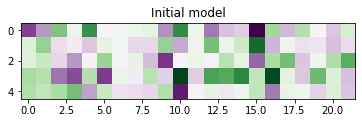

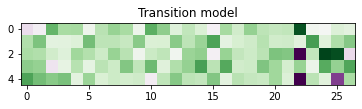

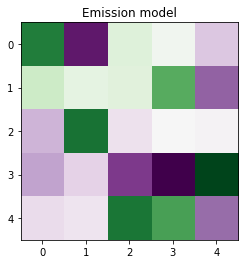

In [275]:
plt.imshow(model.initial_model.weight.detach().numpy(), cmap="PRGn")
plt.title("Initial model")
plt.show()

plt.imshow(model.transition_model.weight.detach().numpy(), cmap="PRGn")
plt.title("Transition model")
plt.show()

plt.imshow(model.emission_model.weight.detach().numpy(), cmap="PRGn")
plt.title("Emission model")
plt.show()

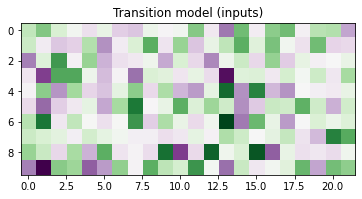

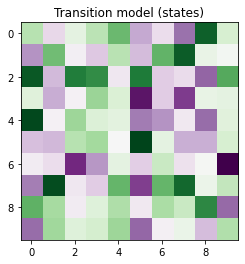

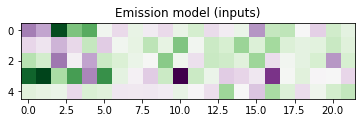

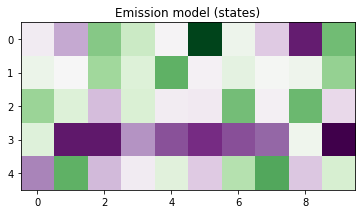

In [252]:
nb_features = X1.shape[-1]
transition_mat = model.transition_model.weight.detach().numpy()

plt.imshow(transition_mat[:,:nb_features], cmap="PRGn")
plt.title("Transition model (inputs)")
plt.show()

plt.imshow(transition_mat[:,nb_features:], cmap="PRGn")
plt.title("Transition model (states)")
plt.show()

emission_mat = model.emission_model.weight.detach().numpy()
plt.imshow(emission_mat[:,:nb_features], cmap="PRGn")
plt.title("Emission model (inputs)")
plt.show()

plt.imshow(emission_mat[:,nb_features:], cmap="PRGn")
plt.title("Emission model (states)")
plt.show()

In [239]:
all_acc = []
for pid in tqdm(np.unique(df['pid'])):
    mask = df['pid'] == pid
    x = X1[mask]
    y = Y[mask]
    
    x = np.reshape(x, (1,*x.shape))
    x = torch.Tensor(x.astype(np.float32))
    y = torch.Tensor(y.astype(np.int64))
    
    y_true = y
    y_pred = model.forward(x)
    y_pred = torch.argmax(y_pred, axis=-1)

    acc = (y_true == y_pred).float().mean().detach().numpy()
    all_acc.append(acc)

all_acc = np.array(all_acc).flatten()

100%|██████████████████████████████████████████████████████████████████████████████████| 77/77 [00:21<00:00,  3.58it/s]


0.7880336441002884


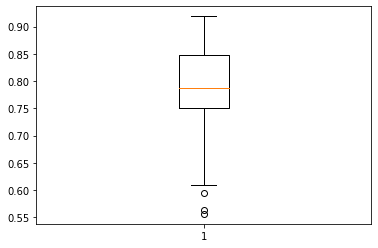

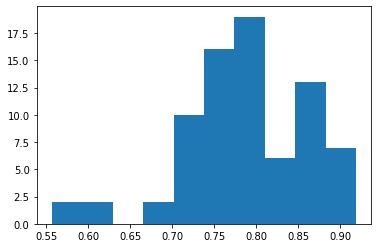

In [240]:
pids = np.unique(df['pid'])
all_lengths = np.array([(df['pid'] == pid).shape[0] for pid in pids])
all_lengths = all_lengths / np.sum(all_lengths)

print(np.sum(all_acc*all_lengths))
# plot distribution of accuracy per patient
_ = plt.boxplot(all_acc)
plt.show()

plt.hist(all_acc, bins=10)
plt.show()

0.8828748890860693
0.8828748890860693


Text(0, 0.5, 'Count')

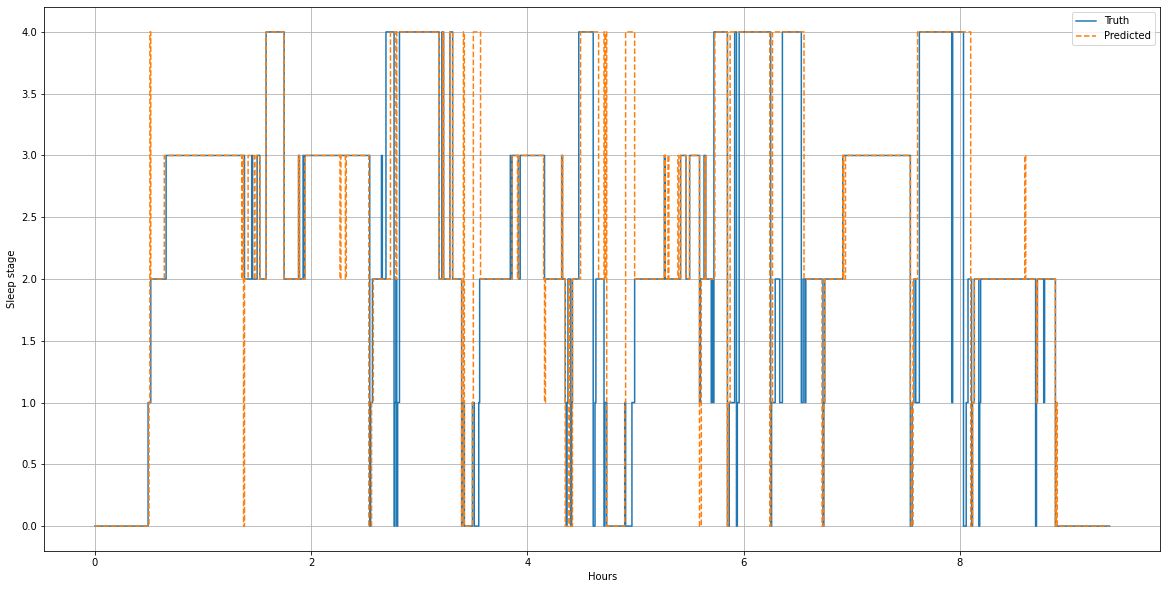

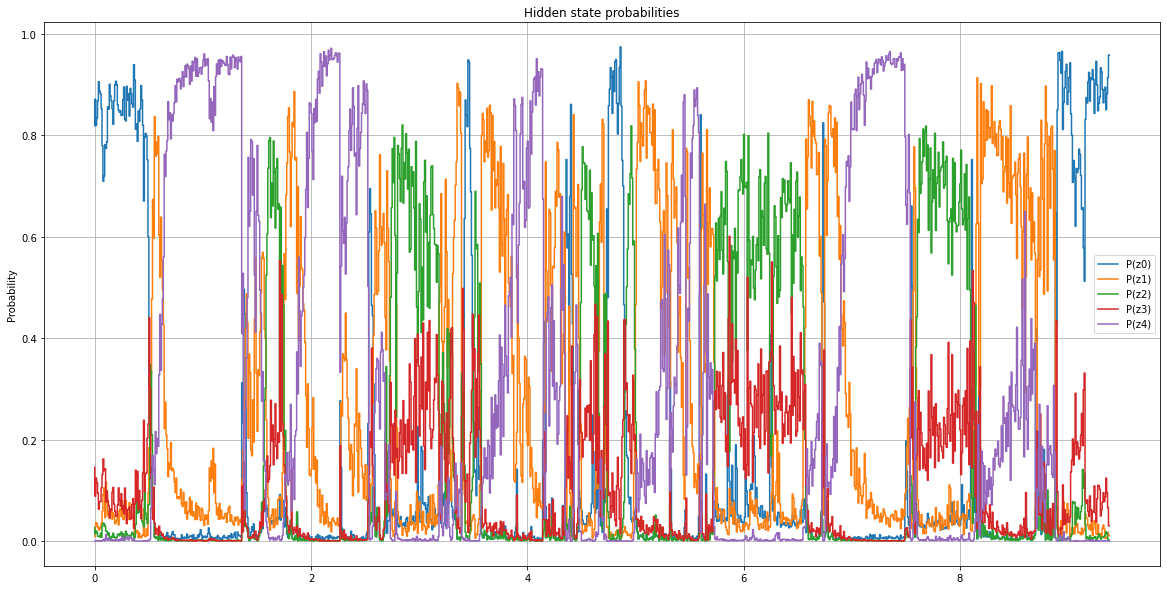

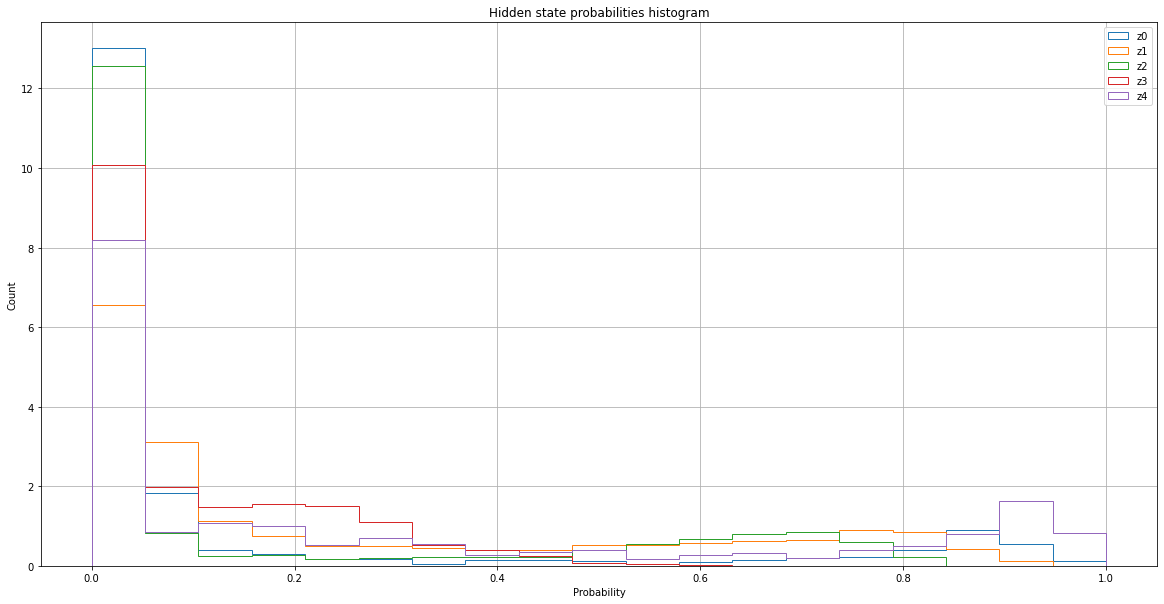

In [272]:
model.eval()

patient_mask = (df['pid'] == 0)
x = X1[patient_mask]
y = Y[patient_mask]

x = np.reshape(x, (1,*x.shape))

x = torch.Tensor(x.astype(np.float32))
y = torch.Tensor(y.astype(np.int64))

y_true = y
y_pred, z = model.forward(x, store_state=True)
y_pred = torch.argmax(y_pred, axis=-1)

y_true = y_true.detach().numpy().flatten()
y_pred = y_pred.detach().numpy().flatten()
z = z.detach().numpy().squeeze(axis=0)
x = x.squeeze(axis=0)

# Plot our true and predicted hypnogram
len_slice = 100
n_slice = 6
#i = np.arange(0, len_slice) + len_slice*n_slice
i = np.arange(0, y.shape[0])
epoch_time = 30
t = i*(epoch_time/3600) # hours
plt.figure(figsize=(20,10))
plt.step(t, y_true[i], label="Truth")
plt.step(t, y_pred[i], linestyle="--", label="Predicted")
plt.grid(True)
plt.legend()
plt.xlabel("Hours")
plt.ylabel("Sleep stage")
print(np.mean(y_pred == y_true))
print(np.mean(y_true[i] == y_pred[i]))

# Plot our hidden state
Nstates = z.shape[-1]
plt.figure(figsize=(20,10))
for j in range(Nstates):
    plt.step(t, z[i,j], label=f"P(z{j})")
plt.legend()
plt.grid(True)
plt.title("Hidden state probabilities")
plt.ylabel("Probability")

# Plot our hidden state histograms
Nstates = z.shape[-1]
plt.figure(figsize=(20,10))

for j in range(Nstates):
    plt.hist(z[i,j], bins=np.linspace(0, 1, 20), histtype=u'step', density=True, label=f"z{j}")
plt.legend()
plt.grid(True)
plt.title("Hidden state probabilities histogram")
plt.xlabel("Probability")
plt.ylabel("Count")

In [273]:
z_df = pd.DataFrame(z[i])
corr = z_df.corr()
corr.style.background_gradient(cmap='coolwarm')

,0,1,2,3,4
0,1.000000,-0.365247,-0.174942,0.107963,-0.412691
1,-0.365247,1.000000,-0.410654,-0.375900,-0.079054
2,-0.174942,-0.410654,1.000000,0.688309,-0.513671
3,0.107963,-0.375900,0.688309,1.000000,-0.640869
4,-0.412691,-0.079054,-0.513671,-0.640869,1.000000


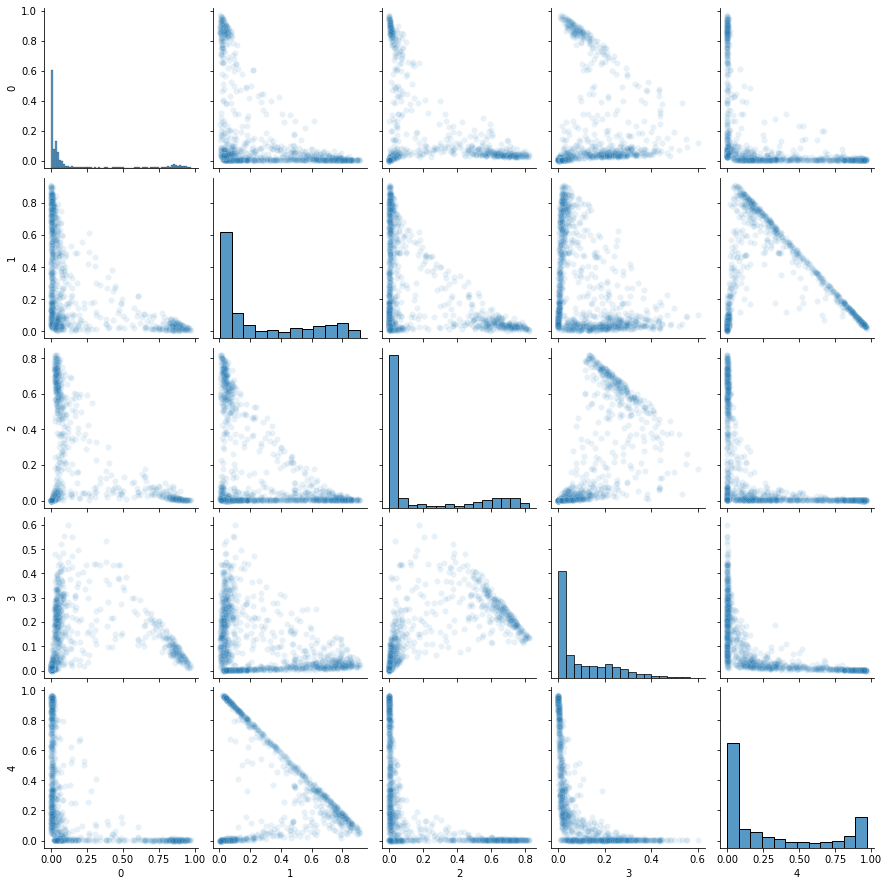

In [274]:
import seaborn as sn

#sn.pairplot(z_df, kind='reg', plot_kws={'line_kws':{'color':'red'}, 'scatter_kws': {'alpha': 0.1}})
sn.pairplot(z_df, kind='scatter', plot_kws={'alpha':0.1})